# Advanced Computational Methods in Statistics
### Gerardo Durán-Martín

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from dataclasses import dataclass
from functools import partial
from jax.scipy import stats
from jsl.lds.kalman_filter import LDS, filter

In [2]:
cblue = "#006AFF"
cblue_light = "#00CCFF"
cred = "#FF0D35"
corange_dark = "#FF4A21"
corange_light = "#FF8D0A"
cpink = "#FF26FF"
cgreen = "#29CC36"
cyellow = "#FADD00"
cpurple = "#9F19FF"
cbrown = "#994926"

In [3]:
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["figure.figsize"] = (8, 3)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[cblue, cgreen, cred, corange_light])

jnp.set_printoptions(precision=5, suppress=True)

We consider the following scalar linear Gaussian model

$$
\begin{aligned}
    X_n &= \rho X_{n-1} + \tau V_n\\
    Y_n &= X_n + \sigma W_n
\end{aligned}
$$
with

* $V_n, W_n \sim \mathcal{N}(0, 1)$
* $X_0 \sim \mathcal{N}(0, 1)$

In [55]:
@dataclass
class SSMConfig:
    rho: float
    tau: float
    sigma: float
    n_particles: int

n_particles = 500
ssm_config = SSMConfig(rho=0.8, tau=1, sigma=0.1, n_particles=n_particles)

In [34]:
def sample_step(x_prev, key, ssm):
    latent_noise, obs_noise = jax.random.normal(key, (2,))
    
    x_next = ssm.rho * x_prev + ssm.tau * latent_noise
    y_next = x_next + ssm.sigma * obs_noise
    
    state = {"x": x_next, "y": y_next}
    return x_next, state

In [35]:
num_timesteps  = 500
key = jax.random.PRNGKey(314)
key, key_init, *key_steps = jax.random.split(key, num_timesteps + 2)
key_steps = jnp.r_[key_steps]
key, key_sis, key_smc = jax.random.split(key, 3)

In [36]:
x_init = jax.random.normal(key_init)

sample_step_part = partial(sample_step, ssm=ssm_config)

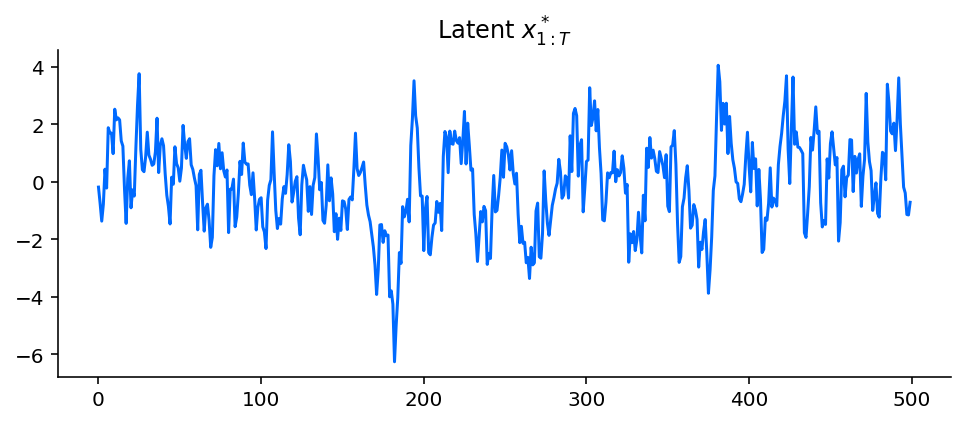

In [37]:
_, hist = jax.lax.scan(sample_step_part, x_init, key_steps)

y_obs = hist["y"]
x_latent = hist["x"]

fig, ax = plt.subplots()
ax.plot(x_latent)
ax.set_title("Latent $x^*_{1:T}$");

# Sequential Importance Sampling (IS)

In [38]:
def sis_step(state, xs, config):
    log_w_prev, x_prev = state
    key, y = xs
    
    x_next = config.rho * x_prev + jax.random.normal(key, (config.n_particles,)) * config.tau
    log_w_next = log_w_prev + stats.norm.logpdf(y, loc=x_next, scale=config.sigma)
    
    carry = {
        "particles": x_next,
        "log_weights": log_w_next
    }
    
    return (log_w_next, x_next), carry


def sis_lssm(key, observations, ssm_config):
    """
    Perform sequential importance sampling (SIS) of a 
    linear state space model (SSM) of the form:
            x_next = rho * x_prev + tau * U
            y_next = x_next + sigma * W
    with U, W ~ N(0, 1).
    With a proposal distribution of the form
    q(x_next | x_prev) = N(x_next | config.rho * x_prev, config.tau ** 2)
    """
    num_timesteps = len(observations)
    key_init, keys_step = jax.random.split(key)
    keys_step = jax.random.split(key, num_timesteps)
    
    log_w_init = jnp.zeros(ssm_config.n_particles)
    x_init = jax.random.normal(key_init, (ssm_config.n_particles,))
    
    init_state = (log_w_init, x_init)
    input_vals = (keys_step, observations)
    
    sis_step_apply = partial(sis_step, config=ssm_config)
    _, res = jax.lax.scan(sis_step_apply, init_state, input_vals)
    
    weights = jnp.exp(res["log_weights"] - jax.nn.logsumexp(res["log_weights"], axis=1, keepdims=True))
    res["weights"] = weights
    
    return res

# Sequential Monte Carlo

In [39]:
def smc_step(state, xs, config):
    w_prev, log_w_prev, x_prev = state
    key, y = xs
    key_resampling, key_proposal = jax.random.split(key)
    
    # Resampling
    x_prev= jax.random.choice(key_resampling, x_prev, shape=(config.n_particles,), p=w_prev)
    
    x_next = config.rho * x_prev + jax.random.normal(key_proposal, (config.n_particles,)) * config.tau
    # log_w_next = log_w_prev + stats.norm.logpdf(y, loc=x_next, scale=config.sigma)
    log_w_next = stats.norm.logpdf(y, loc=x_next, scale=config.sigma)
    
    w_next = jnp.exp(log_w_next - jax.nn.logsumexp(log_w_next))
    
    carry = {
        "particles": x_next,
        "log_weights": log_w_next,
        "weights": w_next,
    }
    
    return (w_next, log_w_next, x_next), carry


def smc_lssm(key, observations, ssm_config):
    """
    Sequential Monte-Carlo linear state-space-model
    
    Perform sequential importance sampling (SIS) of a 
    linear state space model (SSM) of the form:
            x_next = rho * x_prev + tau * U
            y_next = x_next + sigma * W
    with U, W ~ N(0, 1).
    With a proposal distribution of the form
    q(x_next | x_prev) = N(x_next | config.rho * x_prev, config.tau ** 2)
    """
    num_timesteps = len(observations)
    key_init, keys_step = jax.random.split(key)
    keys_step = jax.random.split(key, num_timesteps)
    
    log_w_init = jnp.zeros(ssm_config.n_particles)
    w_init = jnp.exp(log_w_init)
    x_init = jax.random.normal(key_init, (ssm_config.n_particles,))
    
    init_state = (w_init, log_w_init, x_init)
    input_vals = (keys_step, observations)
    
    smc_step_apply = partial(smc_step, config=ssm_config)
    _, res = jax.lax.scan(smc_step_apply, init_state, input_vals)
        
    return res

## Kalman filter

We perfom Kalman filter to compare against our estimated posteriors using particle filtering

In [40]:
lds = LDS(jnp.array([[ssm_config.rho]]), jnp.array([1.0]),
          jnp.array([[ssm_config.tau]]) ** 2, jnp.array([[ssm_config.sigma]]) ** 2,
          jnp.array([0.0]), jnp.array([[1.0]]))

expected_value_kf, covariance_kf, marg_mean, marg_var = filter(lds, y_obs[:, None])

expected_value_kf = expected_value_kf.ravel()
covariance_kf = covariance_kf.ravel()

marg_mean = marg_mean.ravel()
marg_var = marg_var.ravel()

## Estimating expected value

In [41]:
# Sequential importance sampling
sis_res = sis_lssm(key_sis, y_obs, ssm_config)
expected_value_sis = jnp.einsum("tn,tn->t", sis_res["particles"], sis_res["weights"])

In [42]:
# Sequential Monte Carlo
smc_res = smc_lssm(key_smc, y_obs, ssm_config)
expected_value_smc = jnp.einsum("tn,tn->t", smc_res["particles"], smc_res["weights"]).block_until_ready()

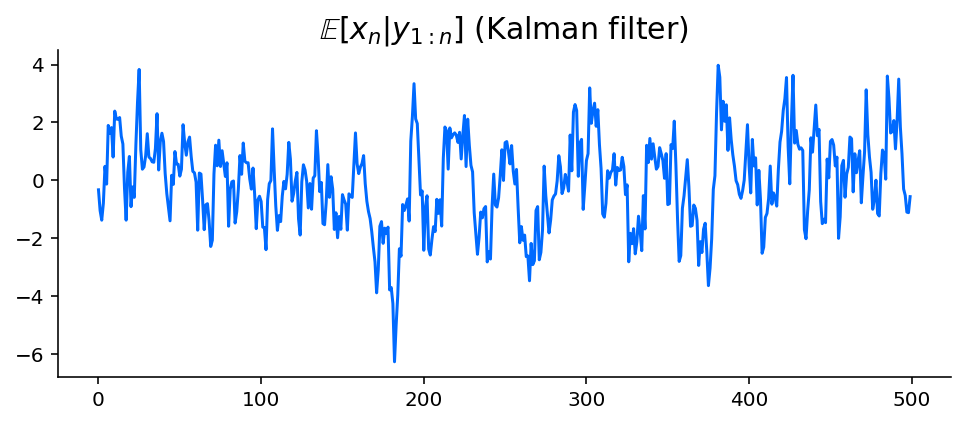

In [43]:
plt.plot(expected_value_kf, label="SIS")
plt.title(r"$\mathbb{E}[x_n \vert y_{1:n}]$ (Kalman filter)", fontsize=15);

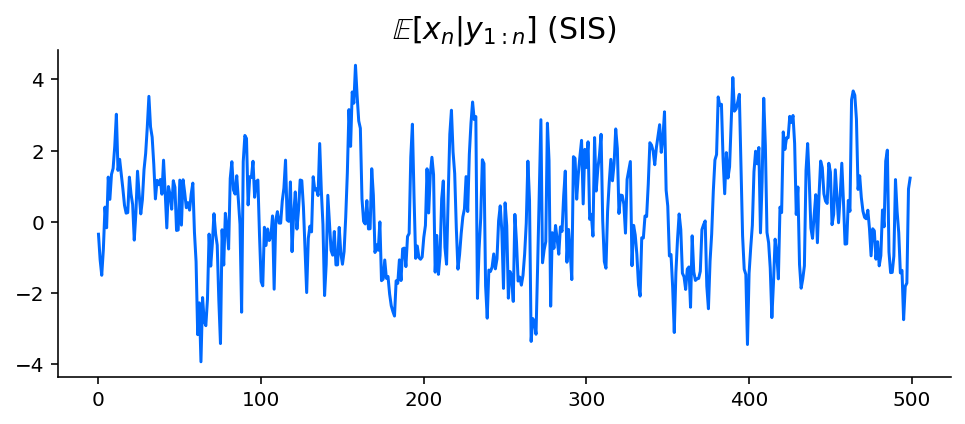

In [44]:
plt.plot(expected_value_sis, label="SIS")
plt.title(r"$\mathbb{E}[x_n \vert y_{1:n}]$ (SIS)", fontsize=15);

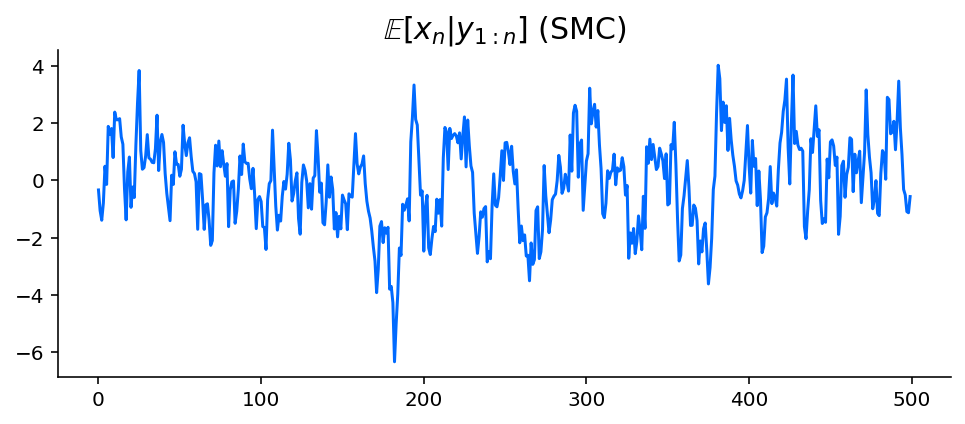

In [45]:
plt.plot(expected_value_smc, label="Particle filter (SMC)")
plt.title(r"$\mathbb{E}[x_n \vert y_{1:n}]$ (SMC)", fontsize=15);

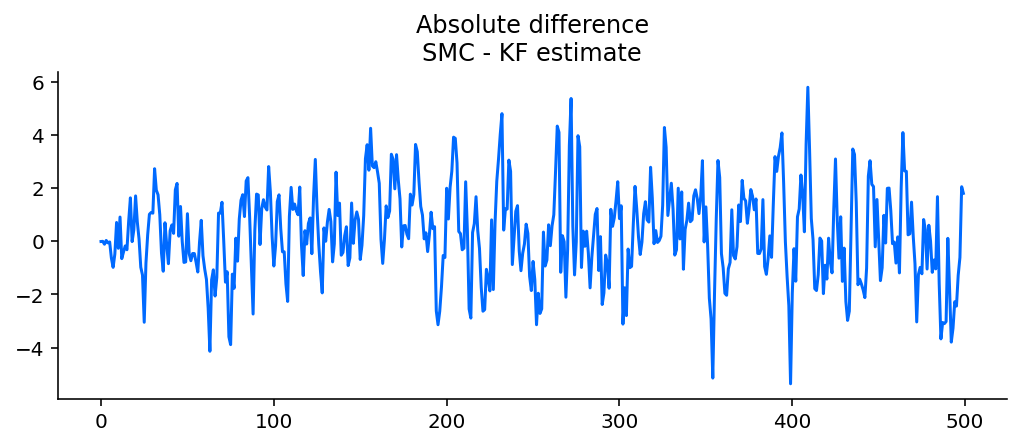

In [46]:
fig, ax = plt.subplots(figsize=(8.5, 3))
plt.plot(expected_value_sis - expected_value_kf)
plt.title("Absolute difference\nSMC - KF estimate");

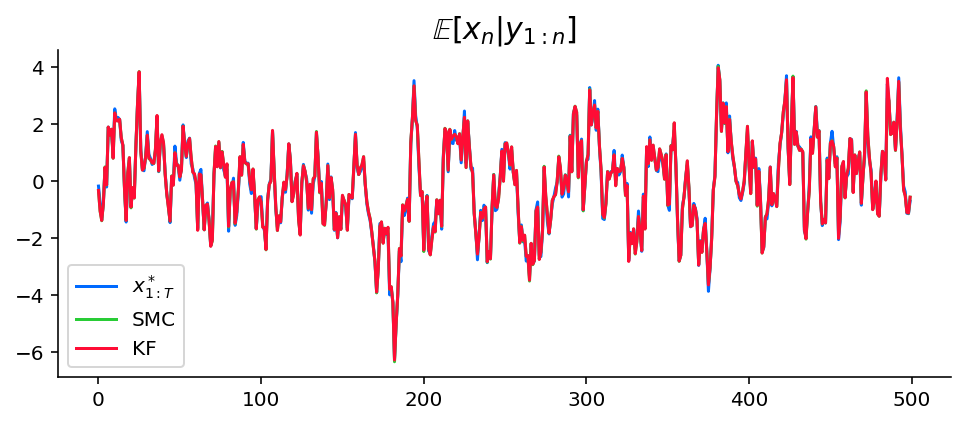

In [47]:
plt.title(r"$\mathbb{E}[x_n \vert y_{1:n}]$", fontsize=15);
plt.plot(x_latent, label="$x^*_{1:T}$")
plt.plot(expected_value_smc, label="SMC")
plt.plot(expected_value_kf, label="KF")
plt.legend()

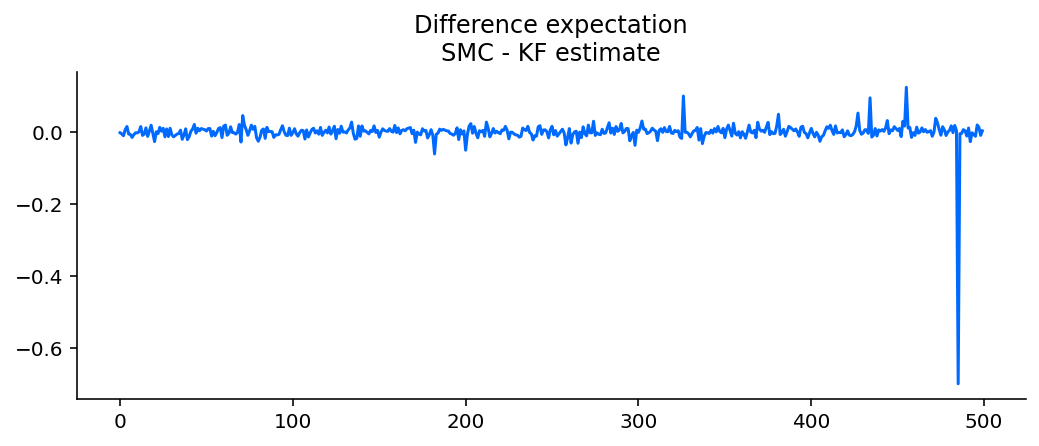

In [48]:
fig, ax = plt.subplots(figsize=(8.5, 3))
plt.plot(expected_value_smc - expected_value_kf)
plt.title("Difference expectation\nSMC - KF estimate");

## Estimating second-order moment $\mathbb{E}[X^2_t \vert Y_{0:t}]$

In [49]:
expected_value_squared_smc = jnp.einsum("tn,tn->t", smc_res["particles"] ** 2, smc_res["weights"]).block_until_ready()
expected_value_squared_kf = covariance_kf + expected_value_kf ** 2

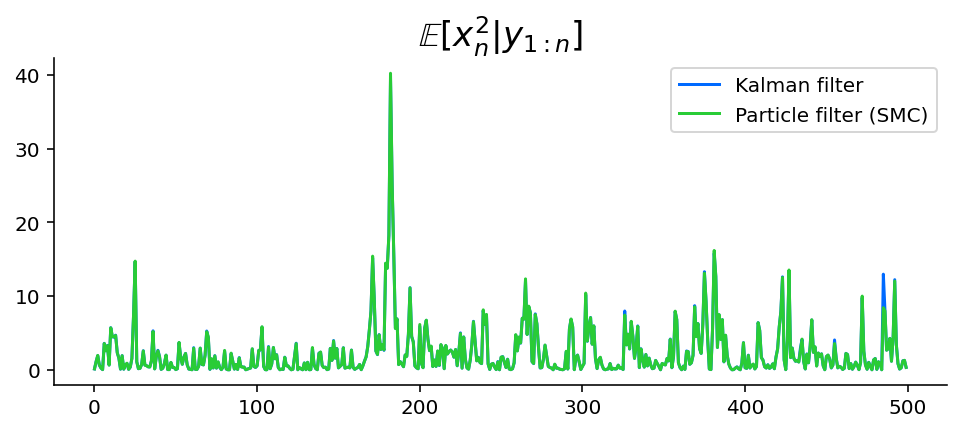

In [50]:
plt.plot(expected_value_squared_kf, label="Kalman filter")
plt.plot(expected_value_squared_smc, label="Particle filter (SMC)")
plt.legend()
plt.title(r"$\mathbb{E}[x_n^2 \vert y_{1:n}]$", fontsize=17);

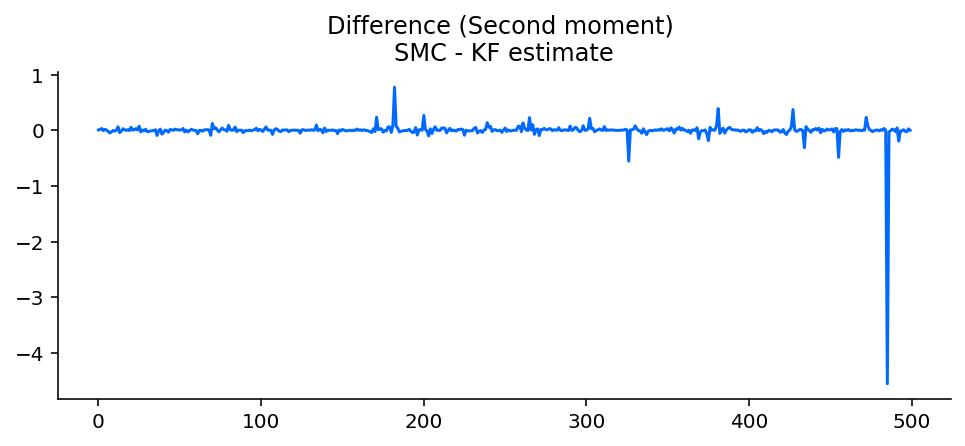

In [51]:
plt.plot(expected_value_squared_smc - expected_value_squared_kf)
plt.title("Difference (Second moment) \nSMC - KF estimate");

## Computing marginal probablity

$$
\begin{aligned}
p(y_{1:t}) &= \int p(y_{1:t}, x_t) dx_t\\
           &= \int p(y_t, y_{1:t-1}, x_t) dx_t
\end{aligned}
$$

In [56]:
ssm_bigger = SSMConfig(rho=0.8, tau=1, sigma=0.1, n_particles=n_particles * 10)
ssm_smaller = SSMConfig(rho=0.8, tau=1, sigma=0.1, n_particles=n_particles // 10)

smc_bigger = smc_lssm(key_smc, y_obs, ssm_bigger)
smc_smaller = smc_lssm(key_smc, y_obs, ssm_smaller)

In [57]:
marginal_ll_pf = jnp.log(jnp.exp(smc_res["log_weights"]).mean(axis=1)).cumsum()
marginal_ll_pf_bigger = jnp.log(jnp.exp(smc_bigger["log_weights"]).mean(axis=1)).cumsum()
marginal_ll_pf_smaller = jnp.log(jnp.exp(smc_smaller["log_weights"]).mean(axis=1)).cumsum()
marginal_ll_kf = stats.norm.logpdf(y_obs, marg_mean, jnp.sqrt(marg_var + ssm_config.sigma ** 2)).cumsum()

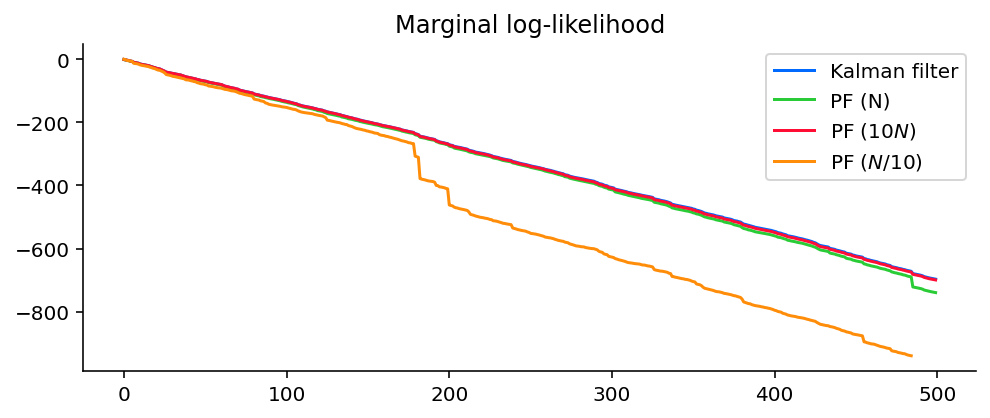

In [58]:
plt.plot(marginal_ll_kf, label="Kalman filter")
plt.plot(marginal_ll_pf, label="PF (N)")
plt.plot(marginal_ll_pf_bigger, label="PF ($10N$)")
plt.plot(marginal_ll_pf_smaller, label="PF ($N/10$)")
plt.title("Marginal log-likelihood")
plt.legend();

# Question 2

## Ideal marginal Metropolis-Hastings


$$
    p(\tau^2) = \text{InvGamma}(\tau^2 | 1, 1) =(1 / \tau^2) ^ 2 \exp(-1/\tau^2)
$$

So that

$$
    \log p(\tau^2) = -2 \log(\tau^2) - 1 / \tau^2
$$

In [126]:
key, key_init, key_sample = jax.random.split(key, 3)

In [82]:
import blackjax

def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states


In [83]:
%%time
ssm_config = SSMConfig(rho=0.8, tau=1, sigma=0.1, n_particles=n_particles)

lds = LDS(jnp.array([[ssm_config.rho]]), jnp.array([1.0]),
          jnp.array([[ssm_config.tau]]) ** 2, jnp.array([[ssm_config.sigma]]) ** 2,
          jnp.array([0.0]), jnp.array([[1.0]]))

# expected_value_kf, covariance_kf, marg_mean, marg_var = filter(lds, y_obs[:, None])
*_, marg_mean, marg_var = filter(lds, y_obs[:, None])

expected_value_kf = expected_value_kf.ravel()
covariance_kf = covariance_kf.ravel()

marg_mean = marg_mean.ravel()
marg_var = marg_var.ravel()

marginal_ll_kf = stats.norm.logpdf(y_obs, marg_mean, jnp.sqrt(marg_var + ssm_config.sigma ** 2)).sum()

CPU times: user 248 ms, sys: 1.74 ms, total: 250 ms
Wall time: 183 ms


In [151]:
def logprob_fn(w, alpha=1.0):
    """The log-probability density function of the posterior distribution of the model."""
    rho, logtau2 = w
    tau2 = jnp.exp(logtau2)
    
    lds = LDS(jnp.array([[rho]]), jnp.array([1.0]),
              jnp.array([[tau2]]), jnp.array([[ssm_config.sigma]]) ** 2,
              jnp.array([0.0]), jnp.array([[1.0]]))
    *_, marg_mean, marg_var = filter(lds, y_obs[:, None])
    
    marginal_ll_kf = stats.norm.logpdf(y_obs, marg_mean.ravel(), jnp.sqrt(marg_var.ravel() + ssm_config.sigma ** 2)).sum()
    log_prior_tau2 = -2 * logtau2 - 1 / tau2
    
    ll = marginal_ll_kf + log_prior_tau2 + jnp.log(1/2)

    return ll


In [152]:
w0 = jax.random.multivariate_normal(key_init, 0.1 + jnp.zeros(2), jnp.eye(2))

rmh = blackjax.rmh(logprob_fn, sigma=jnp.ones(2) * 0.5)
initial_state = rmh.init(w0)

In [153]:
states = inference_loop(key_sample, rmh.step, initial_state, 5_000)

/home/gerardoduran/miniconda3/lib/python3.9/site-packages/jax/_src/tree_util.py:189: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '


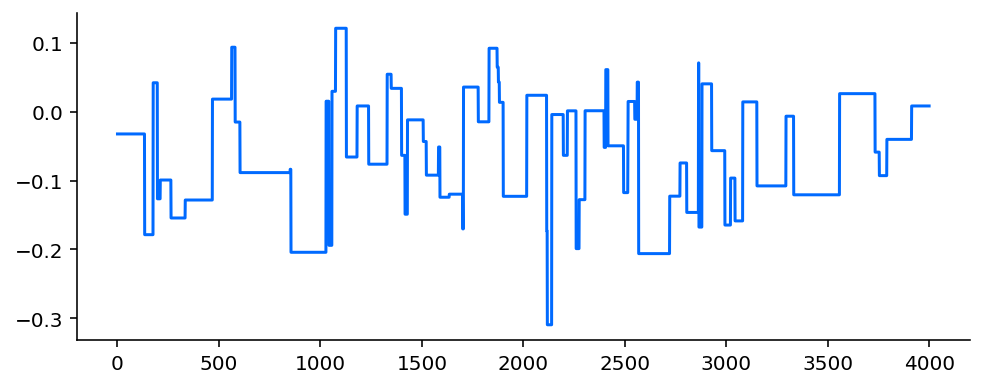

In [154]:
burnin = 1000
plt.plot(states.position[burnin:, 1])

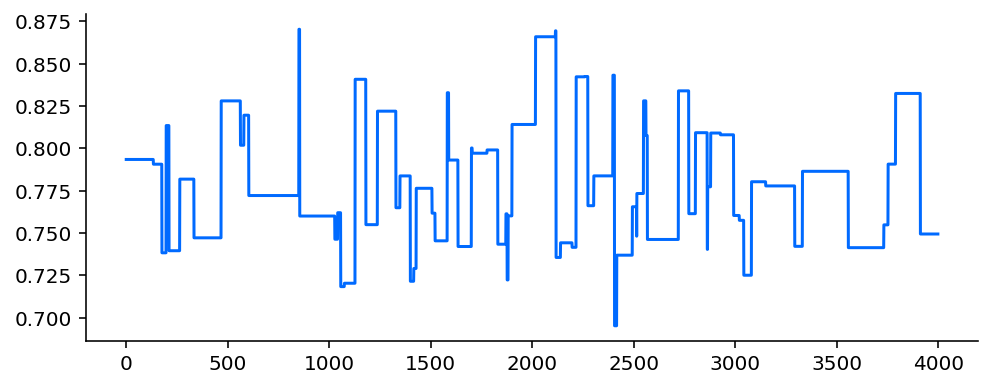

In [155]:
plt.plot(states.position[burnin:, 0])